## Running Notebooks cells, the reproducible way

This modules you on deploying code developed in Notebooks to a Flyte instance for instant reproducibility, versioning and efficient compute access.

### Learning Objectives

Learn how to:

- Create a connection between your Jupyter Notebook and a Flyte cluster
- Build a container image without writing a Dockerfile
- Run code cells on Flyte and retrieve outputs programatically
- Work with execution outputs to perform EDA and then, train a simple Linear Regression model

### Prepare your environment

The [sandbox](https://docs.flyte.org/en/latest/deployment/deployment/sandbox.html#flyte-sandbox-as-a-single-docker-container) is a local Flyte instance that runs on your machine and packs all components of a Flyte cluster into a single Docker container. 
You can start a Flyte instance using `flytectl demo start`. When you do that, it creates a `config-sandbox.yaml` file on your machine, configured to connect you with the Flyte instance.    

For other deployment options, checkout [the docs](https://docs.flyte.org/en/latest/deployment/deployment/index.html).

In [12]:
import os
from pathlib import Path

os.environ["FLYTECTL_CONFIG"] = str(Path.home() / ".flyte/config-sandbox.yaml") #change to ./flyte/config.yaml if not using Flyte sandbox

#### Install the dependencies in your local environment

In [13]:
%pip install -r ./requirements.txt

Note: you may need to restart the kernel to use updated packages.


#### Declare the packages your container image should have, and let [ImageSpec](https://docs.flyte.org/en/latest/user_guide/customizing_dependencies/imagespec.html#imagespec) build it

In [14]:
import flytekit as fl
import sys

custom_image = fl.ImageSpec(
    name="notebooks-flyte-intro",
    requirements="./requirements.txt",
    python_version=f"{sys.version_info.major}.{sys.version_info.minor}",
    registry="localhost:30000",#this is the container registry that ships with Flyte sandbox, but you can use any other
    platform="linux/arm64",
 )

task = fl.task(container_image=custom_image)

### Data ingestion

#### Load the data, defining the prediction target and features the model will use

In [15]:
from dataclasses import dataclass, asdict
from typing import Optional, Tuple
import pandas as pd
from palmerpenguins import load_penguins

TARGET = "species"
FEATURES = [
    "bill_length_mm",
    "bill_depth_mm",
    "flipper_length_mm",
    "body_mass_g",
]

@dataclass
class Hyperparameters:
    C: float
    max_iter: Optional[int] = 2500


@task
def get_data() -> pd.DataFrame:
    return load_penguins()[[TARGET] + FEATURES].dropna()


### Configure the remote object and run the task on Flyte

In [16]:
from flytekit.remote import FlyteRemote
from flytekit.configuration import Config

remote = FlyteRemote(
        Config.for_sandbox(), 
        default_project="flytesnacks", 
        default_domain="development", 
        interactive_mode_enabled=True,  # Optional in notebooks - automatically enabled
    )
task_exec = remote.execute(get_data, inputs={}, wait=True)

11:32:27.928588 WARNING  remote.py:286 - Jupyter notebook and interactive task  
                         support is still alpha.

Image localhost:30000/notebooks-flyte-intro:0JeM7nGYbfCM_eYqOhKKsg found. Skip building.


What just happened is that Flyte executed the `get_data` task and we're capturing the result in the `task_exec` variable.      

`wait=True` means the cell will wait until the execution is completed.


#### Inspect the execution

In [17]:
outputs = task_exec.outputs
print(outputs)

{'o0': 's3://my-s3-bucket/data/hr/ag7qv4cp4tx2f5tm2x4m-getdata-0/94951e0f2820dd3e64a50d633edeeb45'}


This particular task only returns an output (the dataframe from the `load_penguins()` function).    
By default, Flyte uses a standard naming format for outputs, starting with `o0`
([learn how to customize the output names](https://docs.flyte.org/en/latest/user_guide/basics/named_outputs.html#id1)). 

In [18]:
print(task_exec.execution_url)

http://localhost:30080/console/projects/flytesnacks/domains/development/executions/ag7qv4cp4tx2f5tm2x4m


Follow the link above to go to the Flyte console UI, where you can further explore the execution, its inputs, outputs, logs, and more.

With the execution abstracted as an entity and stored in durable storage, we can start manipulating it freely:

### Exploratory Data Analysis (EDA)

In [19]:
dataset = outputs['o0'] #here we retrieve the output from Flyte
print(dataset.head())

  species  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
0  Adelie            39.1           18.7              181.0       3750.0
1  Adelie            39.5           17.4              186.0       3800.0
2  Adelie            40.3           18.0              195.0       3250.0
4  Adelie            36.7           19.3              193.0       3450.0
5  Adelie            39.3           20.6              190.0       3650.0


This gives us an idea of the features and labels available in this dataset.

#### Number of entries in the data set for each species

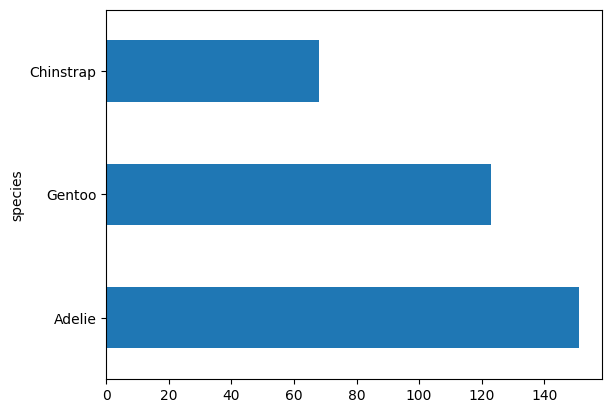

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
dataset['species'].value_counts().plot(kind='barh')
plt.show()

#### Correlation of the variables

Pairplot


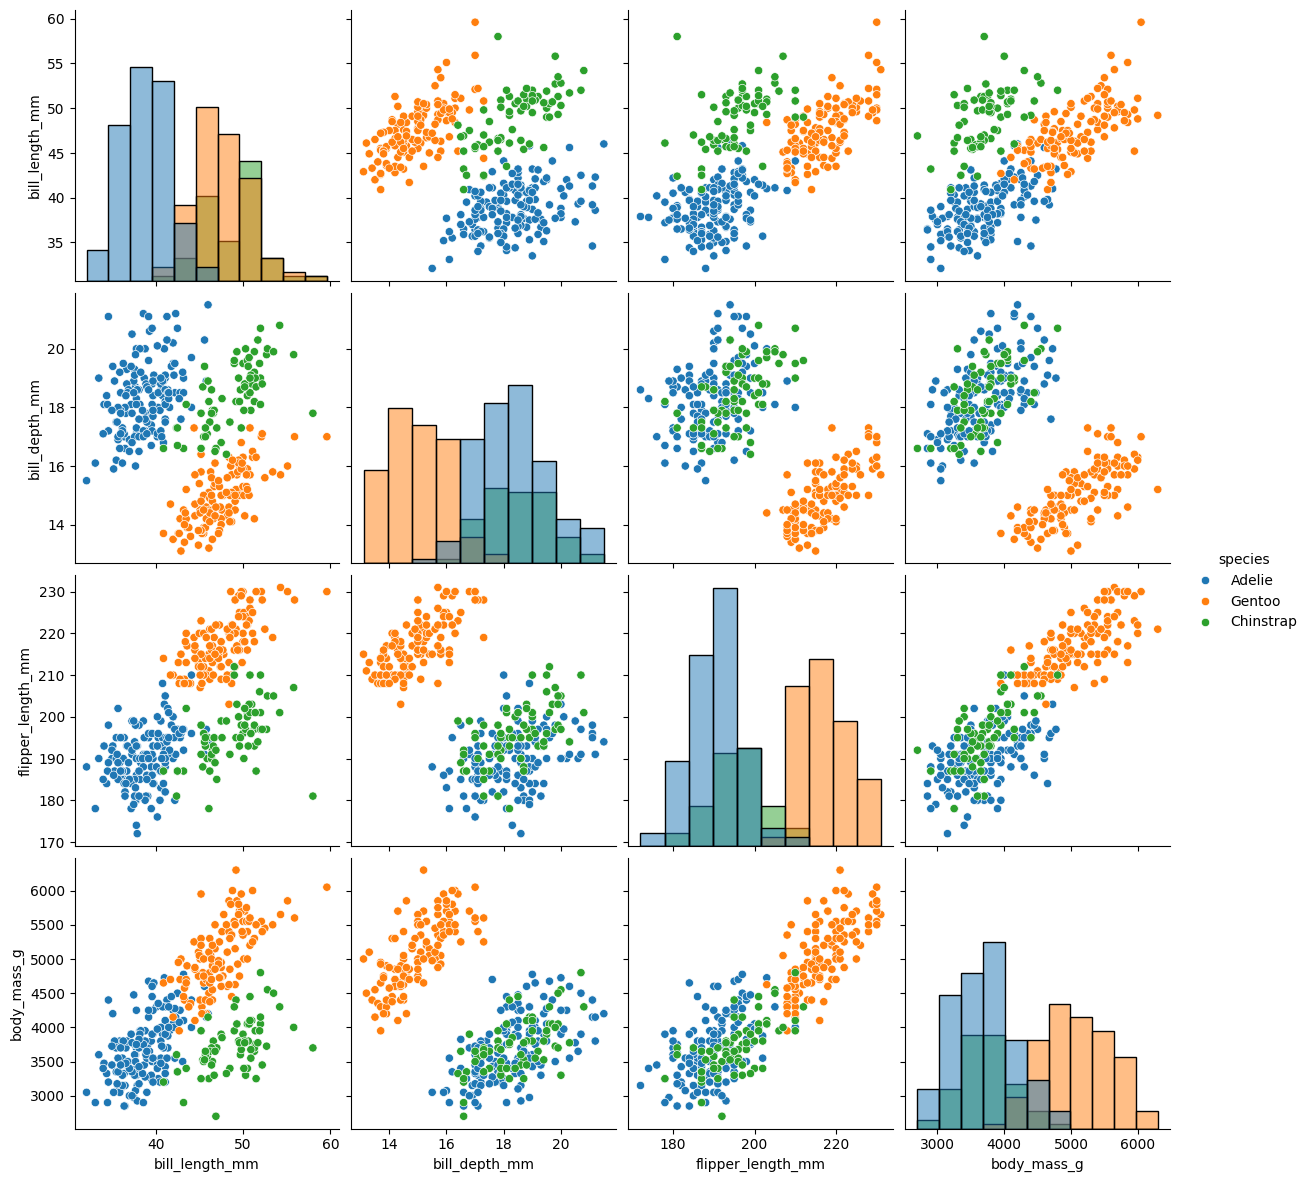

In [21]:
print('Pairplot')
sns.pairplot(data=dataset[['species','bill_length_mm','bill_depth_mm','flipper_length_mm', 'body_mass_g']], hue="species", height=3, diag_kind="hist")
plt.show()

There are additional aspects of the data we could explore, but we have built and understanding of the distribution and potential impact of each feature in the model behavior.

### Split the dataset

In [22]:
from sklearn.model_selection import train_test_split

@task
def split_data(
    data: pd.DataFrame, test_size: float, random_state: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    return train_test_split(
        data,
        test_size=test_size,
        random_state=random_state,
    )

### Model training

#### Train a model using Logistic Regression and calculate the accuracy score

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

@task
def train_model(data: pd.DataFrame, hyperparameters: Hyperparameters) -> LogisticRegression:
    return LogisticRegression(**asdict(hyperparameters)).fit(
        data[FEATURES], data[TARGET]
    )
@task
def evaluate(model: LogisticRegression, data: pd.DataFrame) -> float:
    return float(accuracy_score(data[TARGET], model.predict(data[FEATURES])))


11:33:04.578710 WARNING  type_engine.py:1700 - Unsupported Type <class          
                         'sklearn.linear_model._logistic.LogisticRegression'>   
                         found, Flyte will default to use PickleFile as the     
                         transport. Pickle can only be used to send objects     
                         between the exact same version of Python, and we       
                         strongly recommend to use python type that flyte       
                         support.

### Define a workflow that put all the pieces together

In [24]:
@fl.workflow
def training_workflow(
    hyperparameters: Hyperparameters,
    test_size: float = 0.2,
    random_state: int = 42,
) -> Tuple[LogisticRegression, float, float]: #this is the first output
    # get and split data
    data = get_data()
    train_data, test_data = split_data(
        data=data, test_size=test_size, random_state=random_state
    )
    # train model on the training set
    model = train_model(data=train_data, hyperparameters=hyperparameters)
    # evaluate the model
    train_acc = evaluate(model=model, data=train_data) #second output...
    test_acc = evaluate(model=model, data=test_data)

    # return model with results
    return model, train_acc, test_acc

### Run the workflow

In [27]:
wf_exec = remote.execute(training_workflow, inputs={"hyperparameters": Hyperparameters(C=0.1, max_iter=5000)}, wait = True)
print(wf_exec.execution_url)
print(wf_exec.outputs)

http://localhost:30080/console/projects/flytesnacks/domains/development/executions/amb4qqstgqb48ph5wsb2
{'o2': 0.9855072463768116, 'o0': 's3://my-s3-bucket/data/ah/amb4qqstgqb48ph5wsb2-n2-0/a6b085bf9c60693edfd48fa82470a7b7/08f58d600e16534d411a24a85294728b.joblib', 'o1': 0.9926739926739927}


##### Explore the results

In [30]:
print("Training set accuracy: ", wf_exec.outputs['o1'])
print("Validation set accuracy: ", wf_exec.outputs['o2'])

Training set accuracy:  0.9926739926739927
Validation set accuracy:  0.9855072463768116


Opening up the execution URL, the Flyte console UI shows -among other things- the workflow version:

<image src="static/versioning01.png" width="800px">

If you make a change to the workflow or task code, Flyte will automatically register it as a new task/workflow version so you can have clear tracking and direct reproducibility of your experiment results.   

In the following example, we only change the test dataset size:

In [31]:
@fl.workflow
def training_workflow(
    hyperparameters: Hyperparameters,
    test_size: float = 0.3,
    random_state: int = 42,
) -> Tuple[LogisticRegression, float, float]: #this is the first output
    # get and split data
    data = get_data()
    train_data, test_data = split_data(
        data=data, test_size=test_size, random_state=random_state
    )
    # train model on the training set
    model = train_model(data=train_data, hyperparameters=hyperparameters)
    # evaluate the model
    train_acc = evaluate(model=model, data=train_data) #second output...
    test_acc = evaluate(model=model, data=test_data)

    # return model with results
    return model, train_acc, test_acc

wf_exec = remote.execute(training_workflow, inputs={"hyperparameters": Hyperparameters(C=0.1, max_iter=5000)}, wait = True)
print(wf_exec.execution_url)
print("Training set accuracy: ", wf_exec.outputs['o1'])
print("Validation set accuracy: ", wf_exec.outputs['o2'])

http://localhost:30080/console/projects/flytesnacks/domains/development/executions/a84hjzfhzbfn8tn7289t
Training set accuracy:  0.9926739926739927
Validation set accuracy:  0.9855072463768116


Exploring again from the UI, a new version is associated with this particular execution:

<image src="static/versioning02.png" width="800px">

Moreover, if you click the workflow name in the top breadcrumb (**training_workflow** in this case), you'll find all versions associated with this workflow. Clicking on a version will let you inspect the graph and, hence, the results of a specific executions, including the the inputs and outputs. You can even launch an execution of a past workflow version clicking on **Launch Workflow**.